# Dataset Synthesis

In this jupyter notebook, we will be synthesizing the dataset used for training the model using the Gradrack FM synthesizer

## 1. Imports

In [7]:
import torch                                                   # root package
from torch.utils.data import Dataset, DataLoader, random_split # data loader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np                                             # numpy

import pretty_midi                                             # package for preprocessing midi 


import librosa.display

import matplotlib.pyplot as plt

import sys
import IPython.display as ipd

import os

import math

#import pickle

import pandas as pd

#import torchaudio

import gradrack
from gradrack.generators import ADSR
from gradrack.oscillators import Sinusoid
from gradrack.synths import FMSynth

In [2]:
#Setup the model
##########################

use_cuda = torch.cuda.is_available()
print(use_cuda)
torch.manual_seed(12)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 7, 'pin_memory': True} if use_cuda else {}

torch.cuda.set_device(1)

True


----

## 2. Utility Functions 

Here we must declare some utility functions used for processing midi and synthesizing notes using the Gradrack synth

In [3]:
#Function which takes in a piano roll array and plots it
def plot_piano_roll(piano_roll_array, pitch1, pitch2, fs = 100):
    librosa.display.specshow(piano_roll_array,
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(pitch1))
    

#Function which takes in midi data and converts to input matrix for our input
def create_input_matrix(midi_data, input_length, fs):
    #Create numpy arrays for note onsets, durations, velocities, pitches
    note_onsets = np.zeros(0)
    note_durations = np.zeros(0)
    note_velocities = np.zeros(0)
    note_pitches = np.zeros(0)
    
    truncated_midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)
    
    #Get the onset of the first note of the MIDI and trim the silence before this                
    onsets = midi_data.get_onsets()
    trim = onsets[0]
    #Loop through instruments in midi_data
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                note.start = note.start - trim
                note.end = note.end - trim
                if (note.start < input_length):
                    note_onsets = np.append(note_onsets, note.start)
                    note_durations = np.append(note_durations, note.get_duration())
                    note_velocities = np.append(note_velocities, note.velocity)
                    note_pitches = np.append(note_pitches, note.pitch)
                    
                    piano.notes.append(note)
                    
    truncated_midi.instruments.append(piano)
    
    #Quantize note onsets to discrete time steps
    note_onsets = (note_onsets*fs)
    note_onsets = np.floor(note_onsets)
    note_onsets = note_onsets.astype(int)
    
    #Quantize note durations to discrete time steps
    note_durations = (note_durations*fs)
    note_durations = np.floor(note_durations)
    note_durations = note_durations.astype(int)

    #Convert midi notes to pitches
    note_pitches = note_pitches.astype(int)
    note_pitches = note_pitches - 24
    
    #Calculate the total length of the midi and convert to discrete time steps
    matrix_length = math.ceil((fs * input_length))
    
    onsets = np.zeros((88,matrix_length))
    frames = np.zeros((88,matrix_length))
    
    #Loop through notes and create a matrix of frames and onsets
    for i in range (0, note_pitches.shape[0]):
        onsets[note_pitches[i], note_onsets[i]] = note_velocities[i]
        for j in range(0, note_durations[i]):
            if (note_onsets[i] + j >= matrix_length):
                continue
            else:
                frames[note_pitches[i], note_onsets[i] + j] = note_velocities[i]
    
    #Join the matrices together to form the final input matrix
    input_matrix = np.concatenate((onsets, frames))
    return input_matrix, truncated_midi
    
    

#Function for synthesizing a Pretty Midi file using the FM synth
def synthesize_notes(midi, FMsynth, ratios, adsr_params, operator_gains, clip_length):
    
    
    total_duration = (int)(16000*clip_length)
    final_audio = torch.zeros(total_duration)
    
    #Loop through the notes in the midi and synthesize each one separately
    #Each note needs to be separately synthesized due to a current bug with Gradrack that caused clipping (1/9/2020)
    for note in midi.instruments[0].notes:
        if(note.start < clip_length):

            start = (int)(note.start * 16000)
            end = (int)(note.end * 16000)
            note_duration = end - start
            freq = (2**((note.pitch-69)/12))*440
            gain = note.velocity/127.0

            if((note_duration + start) > total_duration):
                note_duration = total_duration - start
            
            gate = torch.ones(note_duration)
            freq = torch.ones(total_duration)*freq
            
            beginning = torch.zeros(start)
            
            remainder = torch.zeros(total_duration - note_duration - start)
            
            gate = torch.cat((beginning, gate, remainder), 0)
            
            operator_gains = (
                torch.Tensor([gain]),
                torch.Tensor([g2]),
                torch.Tensor([g3])
                )
            
            y = FMsynth(gate, freq, ratios, adsr_params, operator_gains)
            
        final_audio += y
        
    return final_audio


#Function for synthesizing a Pretty Midi file using the FM synth but on the GPU
def synthesize_notesGPU(midi, FMsynth, ratios, adsr_params, operator_gains, clip_length):
    
    total_duration = (int)(16000*clip_length)
    final_audio = torch.zeros(total_duration).cuda()

    for note in midi.instruments[0].notes:
        if(note.start < clip_length):

            start = (int)(note.start * 16000)
            end = (int)(note.end * 16000)
            note_duration = end - start
            freq = (2**((note.pitch-69)/12))*440
            gain = note.velocity/127.0

            if((note_duration + start) > total_duration):
                note_duration = total_duration - start
            
            gate = torch.ones(note_duration).cuda()
            freq = torch.ones(total_duration).cuda()*freq
            
            beginning = torch.zeros(start).cuda()
            
            remainder = torch.zeros(total_duration - note_duration - start).cuda()
            
            gate = torch.cat((beginning, gate, remainder), 0).cuda()
            
            operator_gains = (
                torch.Tensor([gain]).cuda(),
                operator_gains[1],
                operator_gains[2]
                )
            
            
            y = FMsynth(gate, freq, ratios, adsr_params, operator_gains)
            
        final_audio += y
        
    return final_audio

---

## 3. Synthesizing the audio

In this section, the dataset of midi files is synthesized using the Gradrack FM synth. The csv_dir variable holds the path to the csv file containg the parameters of the 12 synth patches. The parameters contained within this CSV file can be replaced as desired.

Please specify the directory you would like to save the audio to in the **audio_dir** variable

Be warned this can take quite a while. If you would like to use the already synthesized dataset in the *synthesized_audio* folder you can skip this and move onto this step!



In [9]:
audio_dir = 'synthesized_audio'

midi_dir = 'midi_dataset'
csv_dir = 'subset_params.csv'
sr = 16000
fs = 125
input_length = 4.096

#Select the number of patches from the CSV file you wish to synthesize the dataset with
num_patches = 12

files = os.listdir(midi_dir)
length = len(files)

#Set up Gradrack FM synth — needs to be constructed with the oscillators and envelopes it will use
oscs = Sinusoid().cuda(), Sinusoid().cuda(), Sinusoid().cuda()
egs = ADSR().cuda(), ADSR().cuda(), ADSR().cuda()
FMsyn = FMSynth(oscs, egs, ((1, 0), (2, 0)), sr)
FMsyn = FMsyn.cuda()

synth_patches = pd.read_csv(csv_dir)

for n in range (0, num_patches):
        
        #Assign synth patch parameters
        a1,a2,a3,d1,d2,d3,g2,g3,r1,r2,r3,s1,s2,s3,t2,t3 = synth_patches.iloc[n, 2:]
        print(synth_patches.iloc[n, 2:])

        #Set the parameters of the gradrack FM synth
        ratios = torch.Tensor([1, t2, t3])
        adsr_params = (
            torch.Tensor([a1, d1, s1, r1]).cuda(),
            torch.Tensor([a2, d2, s2, r2]).cuda(),
            torch.Tensor([a3, d3, s3, r3]).cuda()
        )
        operator_gains = (
            torch.Tensor([1.0]).cuda(),
            torch.Tensor([g2]).cuda(),
            torch.Tensor([g3]).cuda()
        )

        example = 0
        for i in range(length):
                               
            file_name = files[i]

            if file_name == ".ipynb_checkpoints":
                continue

            print(f"Patch:{n}, Example: {example}")

            midi_file_path = os.path.join(midi_dir, file_name)

            #Convert midi file to midi data using pretty_midi
            midi_data = pretty_midi.PrettyMIDI(midi_file_path)

            #Create input matrix which is a concatenation of onsets and frames piano rolls
            input_matrix, short_midi = create_input_matrix(midi_data, input_length, fs)

            #Synthesize the midi file to create the audio target
            audio_data = synthesize_notesGPU(short_midi, FMsyn, ratios, adsr_params, operator_gains, input_length)
            audio_data = audio_data.cpu()
            audio_data.unsqueeze(0)
            
            #Truncate audio to match input length
            output_length_samples = (int)(input_length * sr)
            if (audio_data.shape[0]>output_length_samples):
                audio_data_truncated = audio_data[:output_length_samples]
                audio_data_truncated = audio_data_truncated.numpy()
            else:
                remainder = output_length_samples - audio_data.shape[0]
                audio_data_truncated = np.pad(audio_data, (0, remainder), 'constant')

            if i < 10:
                saved_audio_path = f'{audio_dir}/Patch{n}-Example0{example}.wav'
            else:
                saved_audio_path = f'{audio_dir}/Patch{n}-Example{example}.wav'
            
            #Save the synthesized audio
            librosa.output.write_wav(saved_audio_path, audio_data_truncated, sr, True)
            
            example = example + 1
            

param_attack_1          0.15
param_attack_2          0.15
param_attack_3          0.15
param_decay_1           0.25
param_decay_2           0.25
param_decay_3           0.25
param_gain_2               0
param_gain_3             0.7
param_release_1          0.3
param_release_2          0.3
param_release_3          0.3
param_sustain_1          0.4
param_sustain_2          0.4
param_sustain_3          0.4
param_tuning_2      0.003125
param_tuning_3     0.0104167
Name: 0, dtype: object
Patch:0, Example: 0
Patch:0, Example: 1
Patch:0, Example: 2
Patch:0, Example: 3
Patch:0, Example: 4
Patch:0, Example: 5
Patch:0, Example: 6
Patch:0, Example: 7
Patch:0, Example: 8
Patch:0, Example: 9
Patch:0, Example: 10
Patch:0, Example: 11
Patch:0, Example: 12
Patch:0, Example: 13
Patch:0, Example: 14
Patch:0, Example: 15
Patch:0, Example: 16
Patch:0, Example: 17
Patch:0, Example: 18
Patch:0, Example: 19
Patch:0, Example: 20
Patch:0, Example: 21
Patch:0, Example: 22
Patch:0, Example: 23


KeyboardInterrupt: 


----
## 4. Declaring the dataset

In the following section the dataset is declared and created. For each synth patch, the dataset loads in each midi file in the midi directory, creates the input matrix of frames and onsets, loads the corresponding audio file and creates the corresponding mel-spectrogram to be used as a target for spectrogram prediction. The selected synth patch is identified by a one hot encoded instrument label vector. For example the second synth patch will be identified by the following vector:

\begin{equation*}
\text{Synth Patch 2} =  \begin{vmatrix}
0 \\
1 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\end{vmatrix}
\end{equation*}

This vector is later used by the timbre embedding transformation layer to output a coordinate on the embedding.

In [12]:
class NeuralSynthesisMIDIgradrackload(Dataset):
    def __init__(self, midi_dir,audio_dir, input_length, num_patches, sr = 16000, fs = 125):
        self._midi_dir = midi_dir
        self._audio_dir = audio_dir
        self._files = os.listdir(midi_dir)
        self._input_length = input_length
        self._num_patches = num_patches
        self._sr = sr
        self._fs = fs
        self._data = {}
        self._data_num = 0
        
        length = len(self._files)
        
        for n in range (0, self._num_patches):
            
            label_vector = torch.zeros([self._num_patches, 1], dtype=torch.float64)
            label_vector[n, 0] = 1
            
            example = 0
            
            for i in range(length):
                                
                file_name = self._files[i]

                if file_name == ".ipynb_checkpoints":
                    continue
                
                print(f"Patch:{n}, Example: {example}")
                
                midi_file_path = os.path.join(self._midi_dir, file_name)

                #Convert midi file to midi data using pretty_midi
                midi_data = pretty_midi.PrettyMIDI(midi_file_path)

                #Create input matrix which is a concatenation of onsets and frames piano rolls
                input_matrix, short_midi = create_input_matrix(midi_data, self._input_length, self._fs)

                #Scale velocities to [0,1]
                input_matrix_scaled = input_matrix/127.0

                #Truncate the input matrix to our desired length
                input_length_samples = (int)(self._fs * self._input_length)
                input_matrix_scaled_truncated = input_matrix_scaled[:,:input_length_samples]
                
                if i < 10:
                    saved_audio_path = f'{self._audio_dir}/Patch{n}-Example0{example}.wav'
                else:
                    saved_audio_path = f'{self._audio_dir}/Patch{n}-Example{example}.wav'

                #Synthesize the midi file to create the audio target
                audio_data = librosa.load(saved_audio_path, self._sr, duration=self._input_length)
                audio_data = audio_data[0]           

                output_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=self._sr, S=None, n_fft=1024, n_mels = 80, hop_length=128, norm = 1)
                output_spectrogram = output_spectrogram[:, :512]
                
                self._data[self._data_num] = {'input': input_matrix_scaled_truncated, 'target': output_spectrogram, 'label': label_vector, 'audio': audio_data}
                self._data_num = self._data_num + 1
                example = example + 1
                
        
    def __len__(self):
        return self._data_num
    
    def __getitem__(self,i):
        
        j = i
        return self._data[j]


---
## 5. Loading the dataset
In this section we run the code for loading the dataset.

In [13]:
#Set the directory with midi files
midi_dir = 'midi_dataset'
audio_dir = 'synthesized_audio'

#Declare input length in seconds
input_len = 4.096
num_patches = 12
fs = 125
sr = 16000

# Load custom dataset
dataset = NeuralSynthesisMIDIgradrackload(midi_dir, audio_dir, input_len, num_patches, sr, fs)

Patch:0, Example: 0


/homes/lb311/venv_ecs7013P/lib/python3.6/site-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


Patch:0, Example: 1
Patch:0, Example: 2
Patch:0, Example: 3
Patch:0, Example: 4
Patch:0, Example: 5
Patch:0, Example: 6
Patch:0, Example: 7
Patch:0, Example: 8
Patch:0, Example: 9
Patch:0, Example: 10
Patch:0, Example: 11
Patch:0, Example: 12
Patch:0, Example: 13
Patch:0, Example: 14
Patch:0, Example: 15
Patch:0, Example: 16
Patch:0, Example: 17
Patch:0, Example: 18
Patch:0, Example: 19
Patch:0, Example: 20
Patch:0, Example: 21
Patch:0, Example: 22
Patch:0, Example: 23
Patch:0, Example: 24
Patch:0, Example: 25
Patch:0, Example: 26
Patch:0, Example: 27
Patch:0, Example: 28
Patch:0, Example: 29
Patch:0, Example: 30
Patch:0, Example: 31
Patch:0, Example: 32
Patch:0, Example: 33
Patch:0, Example: 34
Patch:0, Example: 35
Patch:0, Example: 36
Patch:0, Example: 37
Patch:0, Example: 38
Patch:0, Example: 39
Patch:0, Example: 40
Patch:0, Example: 41
Patch:0, Example: 42
Patch:0, Example: 43
Patch:0, Example: 44
Patch:0, Example: 45
Patch:0, Example: 46
Patch:0, Example: 47
Patch:0, Example: 48
P

Patch:3, Example: 93
Patch:3, Example: 94
Patch:3, Example: 95
Patch:3, Example: 96
Patch:3, Example: 97
Patch:3, Example: 98
Patch:3, Example: 99
Patch:4, Example: 0
Patch:4, Example: 1
Patch:4, Example: 2
Patch:4, Example: 3
Patch:4, Example: 4
Patch:4, Example: 5
Patch:4, Example: 6
Patch:4, Example: 7
Patch:4, Example: 8
Patch:4, Example: 9
Patch:4, Example: 10
Patch:4, Example: 11
Patch:4, Example: 12
Patch:4, Example: 13
Patch:4, Example: 14
Patch:4, Example: 15
Patch:4, Example: 16
Patch:4, Example: 17
Patch:4, Example: 18
Patch:4, Example: 19
Patch:4, Example: 20
Patch:4, Example: 21
Patch:4, Example: 22
Patch:4, Example: 23
Patch:4, Example: 24
Patch:4, Example: 25
Patch:4, Example: 26
Patch:4, Example: 27
Patch:4, Example: 28
Patch:4, Example: 29
Patch:4, Example: 30
Patch:4, Example: 31
Patch:4, Example: 32
Patch:4, Example: 33
Patch:4, Example: 34
Patch:4, Example: 35
Patch:4, Example: 36
Patch:4, Example: 37
Patch:4, Example: 38
Patch:4, Example: 39
Patch:4, Example: 40
Pa

Patch:7, Example: 86
Patch:7, Example: 87
Patch:7, Example: 88
Patch:7, Example: 89
Patch:7, Example: 90
Patch:7, Example: 91
Patch:7, Example: 92
Patch:7, Example: 93
Patch:7, Example: 94
Patch:7, Example: 95
Patch:7, Example: 96
Patch:7, Example: 97
Patch:7, Example: 98
Patch:7, Example: 99
Patch:8, Example: 0
Patch:8, Example: 1
Patch:8, Example: 2
Patch:8, Example: 3
Patch:8, Example: 4
Patch:8, Example: 5
Patch:8, Example: 6
Patch:8, Example: 7
Patch:8, Example: 8
Patch:8, Example: 9
Patch:8, Example: 10
Patch:8, Example: 11
Patch:8, Example: 12
Patch:8, Example: 13
Patch:8, Example: 14
Patch:8, Example: 15
Patch:8, Example: 16
Patch:8, Example: 17
Patch:8, Example: 18
Patch:8, Example: 19
Patch:8, Example: 20
Patch:8, Example: 21
Patch:8, Example: 22
Patch:8, Example: 23
Patch:8, Example: 24
Patch:8, Example: 25
Patch:8, Example: 26
Patch:8, Example: 27
Patch:8, Example: 28
Patch:8, Example: 29
Patch:8, Example: 30
Patch:8, Example: 31
Patch:8, Example: 32
Patch:8, Example: 33
Pa

Patch:11, Example: 70
Patch:11, Example: 71
Patch:11, Example: 72
Patch:11, Example: 73
Patch:11, Example: 74
Patch:11, Example: 75
Patch:11, Example: 76
Patch:11, Example: 77
Patch:11, Example: 78
Patch:11, Example: 79
Patch:11, Example: 80
Patch:11, Example: 81
Patch:11, Example: 82
Patch:11, Example: 83
Patch:11, Example: 84
Patch:11, Example: 85
Patch:11, Example: 86
Patch:11, Example: 87
Patch:11, Example: 88
Patch:11, Example: 89
Patch:11, Example: 90
Patch:11, Example: 91
Patch:11, Example: 92
Patch:11, Example: 93
Patch:11, Example: 94
Patch:11, Example: 95
Patch:11, Example: 96
Patch:11, Example: 97
Patch:11, Example: 98
Patch:11, Example: 99


----
## 6. Splitting the dataset

Here we are simply splitting the dataset into training, validation and testing splits

In [15]:
#Create train/test/validation splits
train_set, test_set, val_set = random_split(dataset, (1000, 100, 100))

batch = 50

# Define Dataloaders for training, test and validation sets
train_loader = DataLoader(train_set, batch_size = batch, num_workers = 10)
test_loader = DataLoader(test_set, batch_size = batch, num_workers = 10)
val_loader = DataLoader(val_set, batch_size = batch, num_workers = 10)

----

## 7. Examining the dataset

In the following cells, we are:
1. Loading a batch of samples from our training set.
2. Selecting a sample from the batch and viewing the input matrix of frames and onsets
3. Listening to the audio
4. Viewing the spectrogram we are setting as the target for the model to predict

In [16]:
# 1.
#Get a batch of samples from the training set and check to make sure it is as expected
dataiter = iter(train_loader)
training_samples = dataiter.next()

Target spectrogram shape = torch.Size([80, 512])
Instrument Vector = tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], dtype=torch.float64)


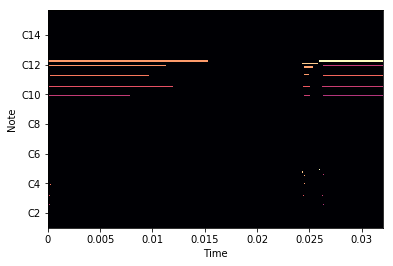

In [22]:
# 2.
#Choose which sample from the current batch to examine
z = 35

# Examine the sample
piano_roll = training_samples['input'][z]
piano_roll = piano_roll.numpy()
plot_piano_roll(piano_roll, 24, 88, 16000)
print(f"Target spectrogram shape = {training_samples['target'][z].shape}")
print(f"Instrument Vector = {training_samples['label'][z]}")

In [20]:
# 3.
audio = training_samples['audio'][z].squeeze(0)
ipd.Audio(audio, rate = 16000) # load a local WAV file

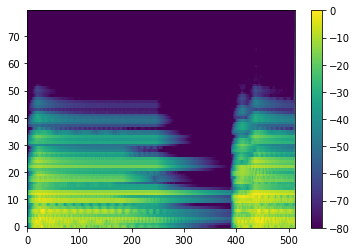

In [19]:
# 4.
# Let's look at the spectrogram of one example
plt.imshow(librosa.power_to_db(training_samples['target'][z], ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

----
## 8. Declaring the model

Now we declare the model architecture as described in the report


In [23]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Mel2Mel(nn.Module):
    def __init__(self,embedding_dimensions, constant_weight=None):
        super(Mel2Mel, self).__init__()
        
        self._embedding_dimensions = embedding_dimensions
        self.embedding_transformation = nn.Linear(num_patches, self._embedding_dimensions, bias = False)
        
        self.tdd = nn.Conv2d(1, 256, (176, 1))
        
        self.gamma1 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        self.beta1 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        
        self.blstm = nn.LSTM(input_size = 256, hidden_size = 128, bidirectional = True)
        
        self.gamma2 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        self.beta2 = nn.Linear (in_features = self._embedding_dimensions, out_features = 256)
        
        self.tdd2 = nn.Conv2d(1, 80, (256, 1))

    def forward(self, x, instrument_label):

        # Add channel dimension to input
        x = x.unsqueeze(1) 
        
        #Send input through first time distributed dense layer and apply ReLU non-linearity
        x = F.relu(self.tdd(x)) 
        
        # Permute to change order to [Time, Batch, Channel, Pitch]
        x = x.permute(3,0,1,2)
        # Flatten to create "features", new shape [Time, Batch, Features (Pitch*Channel)]
        x = torch.flatten(x,2,3)
        
        # FiLM LAYER
        instrument_label = instrument_label.squeeze()
        #Send the batch of instrument lables through the embedding transformation layer to extract the embedding vector
        embedding_vector = self.embedding_transformation(instrument_label)
        gamma1 = self.gamma1(embedding_vector)
        beta1 = self.beta1(embedding_vector)       
        
        #Apply feature wise transformation  or FiLM-ing      
        x = gamma1*x + beta1
        
        
        # BLSTM Layer : Input[Time, Batch, Features (Pitch*Channel)] -> Output[Time, Batch, Features]
        x = self.blstm(x)
      
        # BLSTM outputs a tuple of {output, (hidden states, cell states)}
        # Only use the ouput
        x = x[0]
        
        # FiLM LAYER
        embedding_vector = self.embedding_transformation(instrument_label)
        gamma2 = self.gamma1(embedding_vector)
        beta2 = self.beta1(embedding_vector)
        
        #Apply feature wise transformation 
        x = gamma1*x + beta1
        
        #Permute to get back into a shape 
        x = x.permute(1, 2, 0)
        x = x.unsqueeze(1)
        
        #Send features through final TDD to shape into spectrogram
        x = self.tdd2(x)
        
        # Remove channel dim
        x = x.squeeze()
                
        return x
    
    #This function is used to return the embedding coordinates for a selected instrumetn once the model has trained
    def return_embedding(self, instrument_label):
        
        instrument_label = instrument_label.squeeze()
        embedding_vector = self.embedding_transformation(instrument_label)
        return embedding_vector
   
    #This function skips the embedding transformation layer allows a mel-spectrogram to be
    #generated from a user specified point in the timbre embedding
    def model_with_embedding(self, x, embedding_vector):
        x = x.unsqueeze(1)
        x = F.relu(self.tdd(x)) 
        
        x = x.permute(3,0,1,2)
        
        x = torch.flatten(x,2,3)
        
        # FiLM LAYER
        gamma1 = self.gamma1(embedding_vector)
        beta1 = self.beta1(embedding_vector)        
        
        x = gamma1*x + beta1
        
        x = self.blstm(x)
             
        x = x[0]
        
        # FiLM LAYER
        gamma2 = self.gamma1(embedding_vector)
        beta2 = self.beta1(embedding_vector)
        
        x = gamma1*x + beta1
        
        #Permute to get back into a shape  
        x = x.permute(1, 2, 0)
        x = x.unsqueeze(1)
        x = self.tdd2(x)
        
        # Remove channel dim
        x = x.squeeze()
                
        return x
        
        

----
## 9. Creating the model and training!

In the following cells we finally get to start training

1. Select how many dimensions you want the embedding to project onto an create an instance of the model
2. Create our error function and setup the parameters of the optimizer
3. Declare our training process and start training!

In [24]:
# initialize the NN
embedding_dim = 2
model = Mel2Mel(embedding_dim)
model = model.cuda()

print(model)

Mel2Mel(
  (embedding_transformation): Linear(in_features=12, out_features=2, bias=False)
  (tdd): Conv2d(1, 256, kernel_size=(176, 1), stride=(1, 1))
  (gamma1): Linear(in_features=2, out_features=256, bias=True)
  (beta1): Linear(in_features=2, out_features=256, bias=True)
  (blstm): LSTM(256, 128, bidirectional=True)
  (gamma2): Linear(in_features=2, out_features=256, bias=True)
  (beta2): Linear(in_features=2, out_features=256, bias=True)
  (tdd2): Conv2d(1, 80, kernel_size=(256, 1), stride=(1, 1))
)


In [25]:
eps=1e-7

def log_abs_loss(output, target):
    mag_threshold = 1e-5
    eps = torch.ones_like(output) * mag_threshold
    y_pred = torch.log(torch.max(output, eps))
    y_true = torch.log(torch.max(target, eps))
    loss = torch.mean(torch.abs((y_pred - y_true) ** 2.0))
    return loss

def tanh_log_abs_loss(output, target):
    mag_threshold = 1e-5
    eps = torch.ones_like(output) * mag_threshold
    y_pred = torch.tanh(0.25*(torch.log(torch.max(output, eps))))
    y_true = torch.tanh(0.25*(torch.log(torch.max(target, eps))))
    loss = torch.mean(torch.abs((y_pred - y_true) ** 2.0))
    return loss

# specify loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)

In [26]:
# number of epochs to train the model
n_epochs = 2500
val_loss_min = 1000
minimum_epochs = 0;
patience = 600;

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    val_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        
        sample = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(sample['input'].float().cuda(), sample['label'].float().cuda())
        
        # calculate the loss
        loss = tanh_log_abs_loss(outputs, sample['target'].cuda())
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item()*sample['target'].cuda().size(0)
    
    for data in val_loader:
        val_audio = data 
        outputs = model(sample['input'].float().cuda(), sample['label'].float().cuda())
        #loss = log_abs_loss(outputs, sample['target'].cuda())
        loss = tanh_log_abs_loss(outputs, sample['target'].cuda())
        val_loss += loss.item()*sample['target'].cuda().size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    print('Epoch: {} \tValidation Loss: {:.6f}'.format(
        epoch, 
        val_loss
        ))
    
    if val_loss < val_loss_min:
        saved_model = model
        val_loss_min = val_loss
        minimum_epochs = 0
        print("Improved")
    else:
        minimum_epochs += 1
    if minimum_epochs >= patience:
        #saved_model = model
        print("Early Stopping Now!")
        break
    

Epoch: 1 	Training Loss: 10.543159
Epoch: 1 	Validation Loss: 9.496115
Improved


KeyboardInterrupt: 

----
## 9. Save the model 

Finally we save the model so that we can use it later in the evaluation notebook.

In [27]:
#Save the model for later use
torch.save(saved_model.state_dict(), "MyNeuralSynthesisModel")

---
## 10. Testing the model 

Now that we have trained the model it is time to test it on some unseen test samples

In [73]:
embedding_dim = 2
model = Mel2Mel(embedding_dim)
model = model.cuda()
model.load_state_dict(torch.load("NeuralSynthesisModel2D"))


<All keys matched successfully>

In [33]:
#Evaluate results

#Load test samples
dataiter = iter(test_loader)
test_samples = dataiter.next()

First let's see how the model predicts the mel spectrogram for the original instrument 

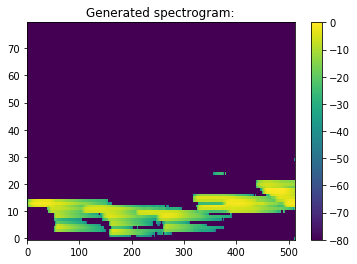

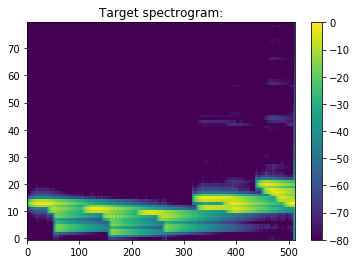

In [92]:
#Select a test sample to test with
j = 2

# Examine one of our training samples for different synth patches
piano_roll = test_samples['input'][j]

output = model(test_samples['input'][j].unsqueeze(0).float().cuda(), test_samples['label'][j].unsqueeze(0).float().cuda())

output = output.cpu().detach().numpy()


plt.figure()
plt.title("Generated spectrogram:")
# Let's look at the spectrogram of one test sample
plt.imshow(librosa.power_to_db(output, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

plt.figure()
plt.title("Target spectrogram:")
# Let's look at the spectrogram of one test sample
plt.imshow(librosa.power_to_db(test_samples['target'][j], ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

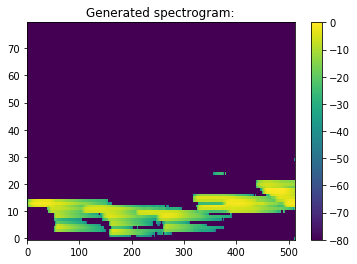

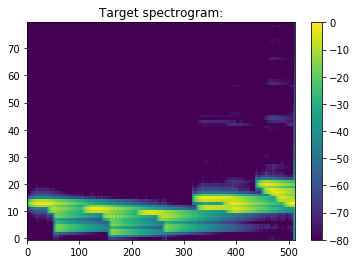

In [92]:
#Select a test sample to test with
j = 2

# Examine one of our training samples for different synth patches
piano_roll = test_samples['input'][j]

output = model(test_samples['input'][j].unsqueeze(0).float().cuda(), test_samples['label'][j].unsqueeze(0).float().cuda())

output = output.cpu().detach().numpy()


plt.figure()
plt.title("Generated spectrogram:")
# Let's look at the spectrogram of one test sample
plt.imshow(librosa.power_to_db(output, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

plt.figure()
plt.title("Target spectrogram:")
# Let's look at the spectrogram of one test sample
plt.imshow(librosa.power_to_db(test_samples['target'][j], ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

---
Now we will predict the mel-spectrogram for the same input in the timbre of each FM patch

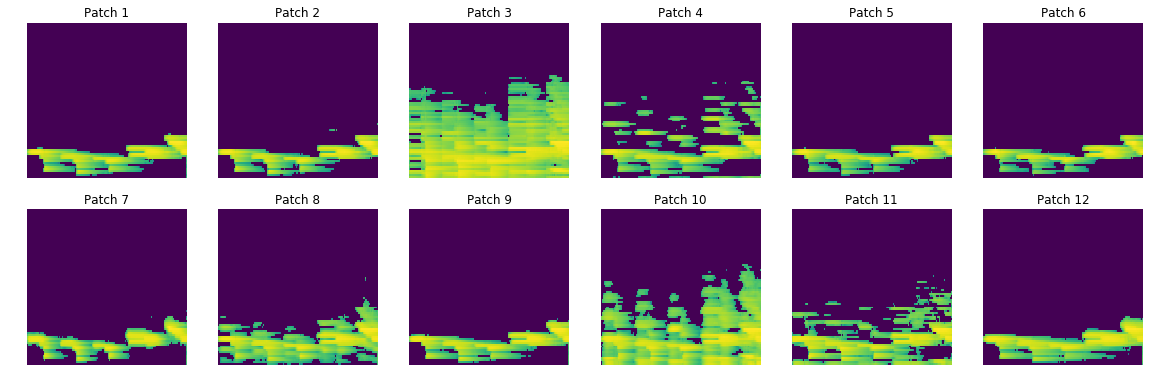

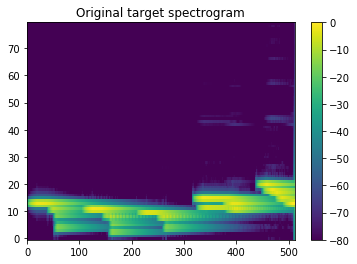

In [111]:
#Select a test sample to test with
j = 2

fig = plt.figure(figsize=(20, 20))

for i in range(0,12):
    #Create input instrument vector
    instrument_vector = torch.zeros([num_patches, 1], dtype=torch.float64)
    instrument_vector[i, 0] = 1
    instrument_vector = instrument_vector.cuda().float()
    
    output = model(test_samples['input'][j].unsqueeze(0).float().cuda(), instrument_vector)
    spec = librosa.power_to_db(output.cpu().detach(), ref=np.max)
    
    fig.add_subplot(6, 6, i+1)
    plt.imshow(spec,aspect='auto', origin='lower')
        
    plt.title(f"Patch {i+1}")
    plt.axis("Off")
    # Let's look at the spectrogram of one test sample

plt.figure()
plt.title(f"Original target spectrogram")
# Let's look at the spectrogram of one test sample
plt.imshow(librosa.power_to_db(test_samples['target'][j], ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

---
## Investigating the generated embedding
In the cells below, we take a closer look at the generated embedding

In [112]:
#This is for checking the embedding vector for each instrument label

#Select a patch to extract the coordinates for
fm_patch_num = 3

#Declare an empty instrument label
instrument_label_vector = torch.zeros([num_patches, 1], dtype=torch.float32)

#Set one of the vector values to 1 to specify which instrument
instrument_label_vector[(fm_patch_num-1), 0] = 1
instrument_label_vector = instrument_label_vector.cuda()
embedding_coord = model.return_embedding(instrument_label_vector)
print(f"FM Patch {fm_patch_num} embedding coordinates = {embedding_coord[0].detach().cpu()},{embedding_coord[1].detach().cpu()}")

FM Patch 3 embedding coordinates = 0.05223070830106735,-0.4259663224220276


## Let's print out the coordinates of each FM patch in the embedding##

In [113]:
instrument_coordinates = torch.zeros([num_patches, embedding_dim])
for i in range (0,num_patches):
    instrument_label_vector = torch.zeros([num_patches, 1], dtype=torch.float32)
    instrument_label_vector[i, 0] = 1
    instrument_label_vector = instrument_label_vector.cuda()
    embedding_coord = model.return_embedding(instrument_label_vector)
    instrument_coordinates[i,:] = embedding_coord.detach()

print(f"Full list of FM patch coordinates in the timbre embedding \n {instrument_coordinates} ")


Full list of FM patch coordinates in the timbre embedding 
 tensor([[-0.3756,  0.3644],
        [-0.3276,  0.4554],
        [ 0.0522, -0.4260],
        [-0.0146,  0.4691],
        [-0.4902,  0.4220],
        [-0.5272,  0.5308],
        [-0.2418,  0.2785],
        [-0.3073, -0.0103],
        [-0.3661,  0.3005],
        [ 0.2073,  0.0133],
        [ 0.2943,  0.4479],
        [-0.5116,  0.1146]]) 


## Now we can visualise the embedding by plotting the points on a graph##

In [116]:
import plotly.graph_objects as go

myData = pd.DataFrame({'dimension_1': instrument_coordinates[:, 0],
                                    'synth_patch': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
                                    'dimension_2': instrument_coordinates[:, 1]})

layout = dict(xaxis=dict(title='Dimension 1'),
              yaxis=dict(title='Dimension 2'))

fig = go.Figure(data=go.Scatter(
    x = myData['dimension_1'], 
    y = myData['dimension_2'],
    text=myData['synth_patch'],
    mode='text+markers',
    marker=dict(
        size=1,
        color=np.random.randn(1000), #set color equal to a variable
        colorscale='greens', # one of plotly colorscales
        showscale=False
    )
),layout = layout)

fig.update_xaxes(range=[-1.0, 1.0])
fig.update_yaxes(range=[-1.0, 1.0])

fig.update_layout(
    width = 1000,
    height = 1000,
    yaxis = dict(
      scaleanchor = "y",
      scaleratio = 1,
    )
)

fig.update_layout(
    font=dict(
        family="Arial, monospace",
        size=20,
    )
)

fig.show()

## This version of the embeddin allows you to click on any of the FM patch points to synthesize in the timbre of that patch

(May not work depending on your environment setup)

In [131]:
f = go.FigureWidget(data = go.Scatter(x = myData['dimension_1'], 
    y=myData['dimension_2'],
    text=myData['synth_patch'],
    mode='text+markers',
    marker=dict(
        size=1,
        color=np.random.randn(1000), #set color equal to a variable
        colorscale='greens', # one of plotly colorscales
        showscale=False
    )), layout = layout)

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 1
f.layout.hovermode = 'closest'

f.update_xaxes(range=[-1.0, 1.0])
f.update_yaxes(range=[-1.0, 1.0])

f.update_layout(
    width = 1000,
    height = 1000,
    yaxis = dict(
      scaleanchor = "y",
      scaleratio = 1,
    )
)

f.update_layout(
    font=dict(
        family="Arial, monospace",
        size=20,
    )
)

# create our callback function
def update_point(trace, points, selector):
    #This is for modelling a midi file based on a point in the embedding
    embedding_coord[0] = points.xs[0]
    embedding_coord[1] = points.ys[0]
    output = model.model_with_embedding(piano_roll, embedding_coord.detach())
    
    # Let's look at the spectrogram of one test sample
    plt.imshow(librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max), aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f"Generated mel spec for FM patch {points.point_inds[0]+1}\n Embedding coordinates = {points.xs[0]}, {points.ys[0]}")

scatter.on_click(update_point)

f.show()

# **Interactive Control Space**

Click anywhere on the WHOLE GRID to generate the mel-spectrogram from that point

In [60]:
x_steps = torch.linspace(-1, 1, steps=100)
y_steps = torch.linspace(-1, 1, steps=100)

x_coord = np.zeros(0)
y_coord = np.zeros(0)

for x in x_steps:
    for y in y_steps:
        x_coord = np.append(x_coord,x)
        y_coord = np.append(y_coord,y)
        

In [61]:
myData = pd.DataFrame({'dimension_1': x_coord,
                                    'dimension_2': y_coord})


f = go.FigureWidget(data = go.Scatter(x = myData['dimension_1'], 
    y=myData['dimension_2'],
    #text=myData['synth_patch'],
    mode='text+markers',
    marker=dict(
        size=1,
        color=np.random.randn(1000), #set color equal to a variable
        colorscale='greens', # one of plotly colorscales
        showscale=False
    )), layout = layout)

scatter = f.data[0]
colors = ['#a3a7e4'] * 100
scatter.marker.color = colors
scatter.marker.size = [10] * 1
f.layout.hovermode = 'closest'

f.update_xaxes(range=[-1.0, 1.0])
f.update_yaxes(range=[-1.0, 1.0])

f.update_layout(
    width = 1000,
    height = 1000,
    title = "2-D Timbre Embedding Space",
    yaxis = dict(
      scaleanchor = "y",
      scaleratio = 1,
    )
)

f.update_layout(
    font=dict(
        family="Arial, monospace",
        size=20,
    )
)

# create our callback function
def update_point(trace, points, selector):
    #This is for modelling a midi file based on a point in the embedding
    embedding_coord[0] = points.xs[0]
    embedding_coord[1] = points.ys[0]
    output = model.model_with_embedding(piano_roll, embedding_coord.detach())
    
    # Let's look at the spectrogram of one test sample
    plt.imshow(librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max), aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f"Generated mel spec for embedding coordinates = {points.xs[0]}, {points.ys[0]}")

scatter.on_click(update_point)

f

FigureWidget({
    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
               …

---
## Manual entry of embedding coordinates

If the interactive 2D graph didn't work you may manually enter any coordinates below

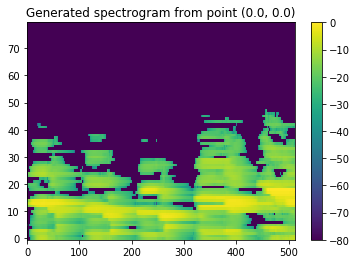

In [138]:
#This is for modelling a midi file based on a point in the embedding

#Enter your chosen coordinates here
embedding_coord[0] = 0
embedding_coord[1] = 0

output = model.model_with_embedding(test_samples['input'][j].unsqueeze(0).float().cuda(), embedding_coord.detach())

# Let's look at the spectrogram of one test sample
plt.title(f"Generated spectrogram from point ({embedding_coord[0]}, {embedding_coord[1]})")
plt.imshow(librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

---
## Mel-Grid

In this final visualisation, we predict the mel-spectrogram for the chosen example at 11 equally spaced points for both dimensions resulting in a 121 x 121 grid

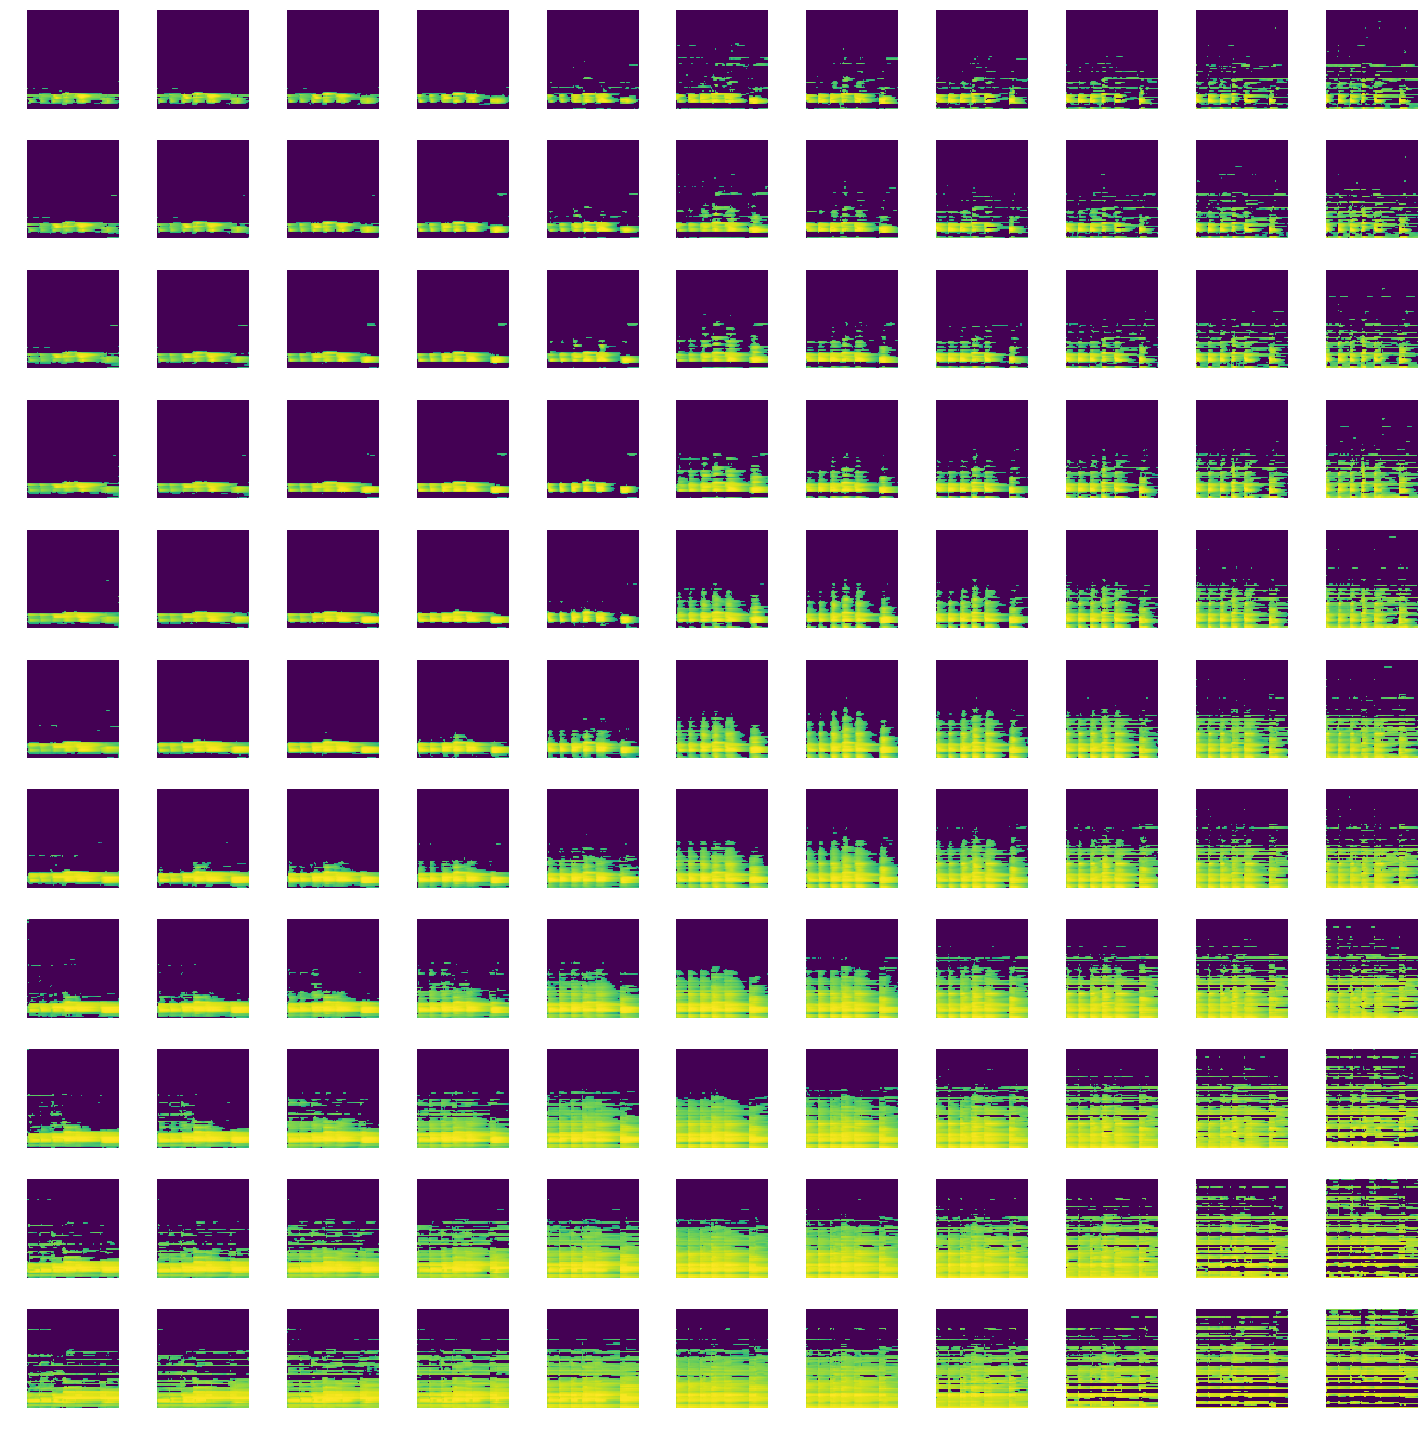

In [130]:
dim1_steps = torch.linspace(-1,1,11)
dim2_steps = torch.linspace(1,-1,11)

fig = plt.figure(figsize=(20, 20))

columns = 11
rows = 11

y = 0
example = 1
for step2 in dim2_steps:    
    
    x = 0
    for step1 in dim1_steps:
        embedding_coord[0] = step1
        embedding_coord[1] = step2
        
        output = model.model_with_embedding(piano_roll, embedding_coord.detach())
        # Let's look at the spectrogram of one test sample
        spec = librosa.power_to_db(output.detach().cpu().numpy(), ref=np.max)
        fig.add_subplot(rows, columns, example)
        plt.imshow(spec,aspect='auto', origin='lower')
        plt.axis('off')
       # plt.title(f"{step1:.2}, {step2:.2}", loc = 'left')
        example += 1
        #plt.savefig(f"mel_predictions/{step1}-{step2}.png")

fig.tight_layout()
plt.savefig(f"mel_predictions/grid.png")    